In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

np.random.seed(1)

# Problema

$-\frac{du}{dx} = f$

In [36]:
N = 50 #quantidade de pontos
u = 2*(np.random.rand(N+2) - 0.5)
u[0] = 0; u[-1] = 0;
u_ant = np.copy(u)

x = np.linspace(0.0, 1.0, num=N+2, endpoint=True)

h = 1.0/(N+1)

f = lambda x: 2
sol = lambda x: x*(1-x)

sol_vec = np.apply_along_axis(sol, 0, np.copy(x))


In [37]:
print len(x), len(u)

52 52


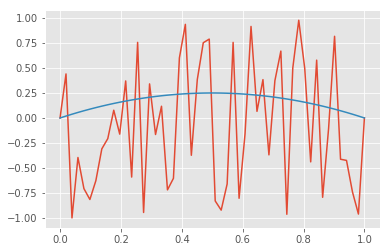

In [38]:
plt.plot(x, u)
plt.plot(x,sol_vec)

In [39]:
def GS(u, f):
    for i in range(1, len(u) - 1):
        u[i] = 0.5*(h*h*f(i*h) + u[i-1] + u[i+1])
    
def Jacobi(u, u_ant, f):
    for i in range(1, len(u) - 1):
        u[i] = 0.5*(h*h*f(i*h) + u_ant[i-1] + u_ant[i+1])    

# Gauss Seidel

In [40]:
erro = 1
iteracoes = 0
while erro > 1e-6:
    GS(u,f)
    erro = np.linalg.norm(u-sol_vec)
    iteracoes += 1

print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)

Numero de iteracoes = 3704	Erro = 9.973120e-07


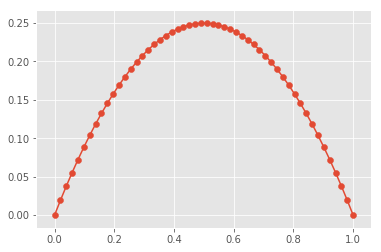

In [41]:
plt.plot(x,u)
plt.scatter(x,sol_vec)

# Jacobi

In [42]:
erro = 1
iteracoes = 0
while erro > 1e-6:
    Jacobi(u,u_ant,f)
    Jacobi(u_ant, u, f)
    erro = np.linalg.norm(u_ant-sol_vec)
    iteracoes += 2

print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)

Numero de iteracoes = 7576	Erro = 9.962600e-07


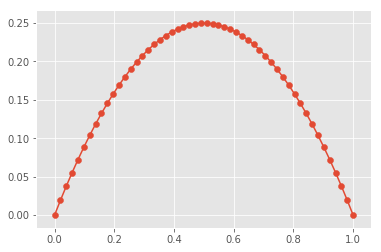

In [43]:
plt.plot(x,u_ant)
plt.scatter(x,sol_vec)

In [44]:
n = 4
h = 1.0/(2*n)
x = np.linspace(0.0, 1.0, num=2*n+1, endpoint=True)
x_n = np.linspace(0.0, 1.0, num=100, endpoint=True)

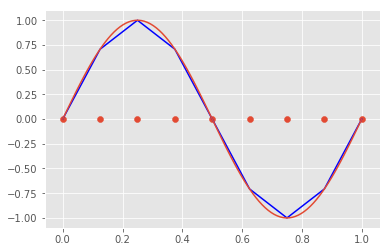

In [45]:
alpha = 1
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)

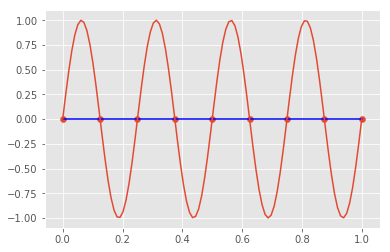

In [46]:
alpha = n
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)

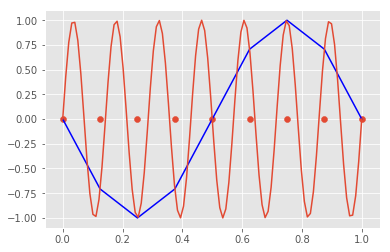

In [47]:
alpha = 2*n-1
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)